# Analysis of Lasso and Random Forest Models for Predicting Overall Survival in KIRC: Assessing the Contribution of miRNA Data

###### Amrita Nagasuri<br>Final Project

##### The Cancer Genome Atlas (TCGA) Program aims to molecularly characterize over 20000 samples spanning both healthy and cancerous tissues. The collected data improves researchers’ abilities to diagnose, treat, and prevent cancer. This project uses a subset of the TCGA which focuses on Kidney Renal Clear Cell Carcinoma (KIRC). The data includes both clinical covariates (age, gender, stage, grade, survival) and molecular features (miRNA, mRNA, and CNV). MicroRNAs (miRNAs), which are non-coding RNA, are important in regulating gene expression and have been implicated in many biological processes including cancer development and progression. Their distinct expression patterns in tumors suggest their potential as valuable biomarkers for prediction. With comprehensive miRNA expression data and clinical information available in the KIRC dataset, we can consider to what degree the miRNA profiles actually improve prediction of survival status beyond just the clinical factors. 

##### _This project focuses on how integrating miRNA expression data with clinical data would help with the prediction of overall survival in patients with KIRC._

##### This project is a retrospective analysis of a pre-existing dataset. As mentioned earlier, the KIRC is part of the TCGA. The dataset contains a total of 234 subjects (n = 234) and over 16,000 features, including clinical variables, copy number variation (CNV), mRNA, and miRNA expression data. For the scope of this project, I focused on miRNA expression data as the molecular feature set. Prior to modeling, an exploratory analysis of the dataset was performed by looking at its structure, variable types, and dimensions. It was confirmed that there were no missing values in any of the variables of interest, therefore, no imputation was required. The variable that was selected for prediction is OS_vital_status which is a binary variable indicating the survival status of the patient (0 for alive or 1 for deceased) at the time of the last follow-up. The central question to explore is whether including miRNA expression data in the prediction models would affect their accuracy in predicting patient status. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
def bootstrap_auc_ci(y_true, y_prob, n_bootstraps=1000, ci=0.95, seed=42):
    rng = np.random.RandomState(seed)
    aucs = []

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue  
        auc = roc_auc_score(y_true[indices], y_prob[indices])
        aucs.append(auc)

    sorted_aucs = np.sort(aucs)
    lower = np.percentile(sorted_aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(sorted_aucs, (1 + ci) / 2 * 100)
    return lower, upper

In [3]:
def permutation_auc_p_value(y_true, y_prob, n_permutations=1000, seed=42):
    rng = np.random.RandomState(seed)
    observed_auc = roc_auc_score(y_true, y_prob)
    permuted_aucs = []

    for _ in range(n_permutations):
        y_true_perm = rng.permutation(y_true)
        auc = roc_auc_score(y_true_perm, y_prob)
        permuted_aucs.append(auc)

    p_value = np.mean([auc >= observed_auc for auc in permuted_aucs])
    print(f"Observed AUC: {observed_auc}, Permuted mean AUC: {np.mean(permuted_aucs)}")
    return p_value
    


In [4]:
# Load data
df = pd.read_csv("/Users/amritanagasuri/Documents/Spring 2025/DATASCI 223/final/Cancer Survival Data.csv")
miRNA_vars = [col for col in df.columns if col.startswith("miRNA_")]
clinical_vars = ["age", "gender", "grade", "stage"]
outcome_var = "OS_vital_status"

In [5]:
# Preprocess miRNA data
df[miRNA_vars] = df[miRNA_vars].apply(pd.to_numeric, errors='coerce')

##### KIRC contains 1045 miRNA variables representing their expression levels. Due to the high dimensionality of the data, it is necessary to visualize the distribution and correct for any skewness. When visualizing the raw miRNA columns, it was heavily left-skewed. First, log-transformation was used to address the skewness but had minimal effect. With further research, quantile normalization was implemented using the preprocessCore package. Since the KIRC dataset includes only one cancer type, the overall distribution of miRNA expression is expected to be similar across samples. Given that the goal of this project is to evaluate the impact of miRNA expression on survival prediction models, rather than identify differentially expressed miRNAs, quantile normalization is appropriate to reduce technical variation. 

In [6]:
# Quantile normalization
qt = QuantileTransformer(output_distribution='normal', copy=True)
normalized_miRNA = pd.DataFrame(qt.fit_transform(df[miRNA_vars]), columns=miRNA_vars)

/Users/amritanagasuri/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (243). n_quantiles is set to n_samples.
  warnings.warn(


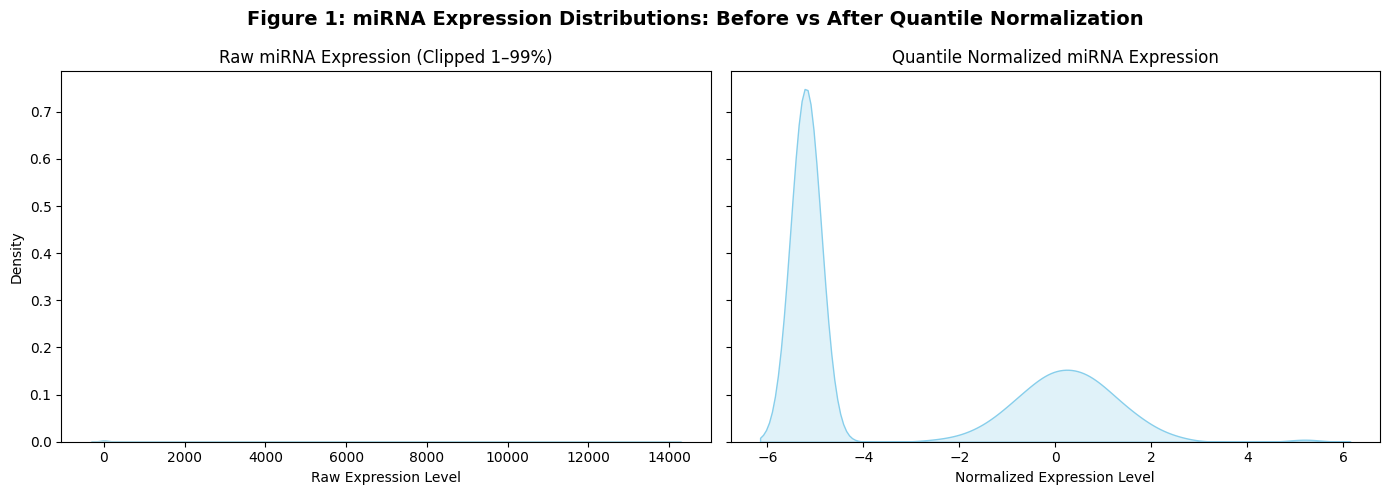

In [33]:
# Recalculate cleaned raw expression
raw_miRNA_clean = df[miRNA_vars].apply(pd.to_numeric, errors='coerce')
raw_miRNA_long = raw_miRNA_clean.melt(var_name="miRNA", value_name="expression").dropna()

# Clip both ends (1st to 99th percentile)
low, high = raw_miRNA_long["expression"].quantile([0.01, 0.99])
raw_miRNA_long = raw_miRNA_long[(raw_miRNA_long["expression"] >= low) & (raw_miRNA_long["expression"] <= high)]

# Same for normalized (optional: less clipping needed here)
normalized_miRNA_long = normalized_miRNA.melt(var_name="miRNA", value_name="normalized_expression").dropna()

# Sample for speed
raw_sample = raw_miRNA_long.sample(n=50000, random_state=42) if len(raw_miRNA_long) > 50000 else raw_miRNA_long
norm_sample = normalized_miRNA_long.sample(n=50000, random_state=42) if len(normalized_miRNA_long) > 50000 else normalized_miRNA_long

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.kdeplot(data=raw_sample, x="expression", fill=True, ax=axes[0], color='lightblue')
axes[0].set_title("Raw miRNA Expression (Clipped 1–99%)")
axes[0].set_xlabel("Raw Expression Level")

sns.kdeplot(data=norm_sample, x="normalized_expression", fill=True, ax=axes[1], color='skyblue')
axes[1].set_title("Quantile Normalized miRNA Expression")
axes[1].set_xlabel("Normalized Expression Level")

plt.suptitle("Figure 1: miRNA Expression Distributions: Before vs After Quantile Normalization", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


##### Figure 1: These density plots compare the miRNA expression data distribution prior to and after using quantile normalization to address its extremely skewed values. The figure on the left is the over density distribution of raw miRNA expression. There is a very small peak around the 0 of the x axis. The distribution has a density of values concentrated near zero, with a long and sparse tail extending towards the higher expression levels. The figure on the right shows the density distribution of miRNA expression levels after undergoing quantile normalization. This preprocessing method transforms the data to achieve a more symmetrical normal distribution. This allows the miRNA features to be more comparable across samples and reduce impact of variation, making it ready for downstream analysis.

In [8]:
# Combine with clinical + outcome
df_combined = pd.concat([df.drop(columns=miRNA_vars), normalized_miRNA], axis=1)

In [9]:
# One-hot encode categorical variables
categorical_cols = df_combined[clinical_vars].select_dtypes(include=['object']).columns.tolist()
numerical_cols = list(set(clinical_vars) - set(categorical_cols))

In [10]:
# Define outcome and features
X = df_combined[clinical_vars + miRNA_vars]
y = df_combined[outcome_var]

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [12]:
# Preprocessing pipeline
numeric_transformer = make_pipeline(SimpleImputer(strategy='mean'))
categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first'))

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop')

In [14]:
# Separate pipelines for clinical and combined
X_train_clinical = df_combined.loc[X_train.index, clinical_vars]
X_test_clinical = df_combined.loc[X_test.index, clinical_vars]

In [15]:
X_train_combined = df_combined.loc[X_train.index, clinical_vars + miRNA_vars]
X_test_combined = df_combined.loc[X_test.index, clinical_vars + miRNA_vars]

In [16]:
# Preprocess
X_train_clinical_prep = preprocessor.fit_transform(X_train_clinical)
X_test_clinical_prep = preprocessor.transform(X_test_clinical)

In [17]:
X_train_combined_prep = np.hstack([X_train_clinical_prep, normalized_miRNA.loc[X_train.index].values])
X_test_combined_prep = np.hstack([X_test_clinical_prep, normalized_miRNA.loc[X_test.index].values])

##### After normalization, outlier detection is the usual next step. Although the outliers may be identified, they should not removed from the dataset for modeling. This is because extreme values in biological expression data can represent true biological variation and not just human error. Furthermore, I am using Lasso Logistic Regression and Random Forest models which are relatively robust to the presence of outliers compared to simpler models such as linear regression. 

### The Models: 

#### Logistic Regression with Lasso (L1) Regularization in Python

##### Logistic Regression is a supervised machine learning algorithm used to estimate the probability that a given instance belongs to a particular class. In this project, we use it to predict whether a patient's status is Alive or Deceased. Given that our dataset contains more features than observations (n = 234 samples, 1046 miRNA variables), the model is at high risk of overfitting. To address this, we apply Lasso (L1) regularization, which adds a penalty to the logistic regression model based on the absolute size of the coefficients. This causes many of the less informative feature coefficients to shrink to zero, effectively performing feature selection and yielding a sparser, more interpretable model.

##### We implemented Lasso logistic regression using the LogisticRegressionCV class from sklearn.linear_model, specifying penalty='l1' and using the liblinear solver to support L1 regularization. Model strength (regularization parameter C, the inverse of lambda) was selected via 10-fold cross-validation, optimizing for the highest average AUC score rather than accuracy, as AUC better captures how well the model ranks patient risk. The optimal model was then evaluated on a held-out test set.

In [18]:
# Lasso Logistic Regression (clinical only)
lasso_clinical = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='saga', scoring='roc_auc', max_iter=10000, random_state=42)
lasso_clinical.fit(X_train_clinical_prep, y_train)
pred_clinical_prob = lasso_clinical.predict_proba(X_test_clinical_prep)[:, 1]
pred_clinical = lasso_clinical.predict(X_test_clinical_prep)

In [19]:
# Lasso Logistic Regression (clinical + miRNA)
lasso_combined = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='saga', scoring='roc_auc', max_iter=10000, random_state=42)
lasso_combined.fit(X_train_combined_prep, y_train)
pred_combined_prob = lasso_combined.predict_proba(X_test_combined_prep)[:, 1]
pred_combined = lasso_combined.predict(X_test_combined_prep)

#### Random Forest Modeling in Python

##### To benchmark against Lasso regression, we also trained Random Forest classifiers, an ensemble method that aggregates multiple decision trees built on bootstrap-resampled data and random subsets of features. Random Forests are especially useful for capturing non-linear relationships and feature interactions, and they are generally robust to noise and overfitting.

##### We implemented Random Forests using the RandomForestClassifier from sklearn.ensemble, setting n_estimators=130 (number of trees), max_depth=5 for the clinical-only model and max_depth=4 for the combined model to control tree complexity. The max_features parameter (equivalent to mtry) was set to 'sqrt', ensuring that a random subset of features is considered at each split. This stochastic approach promotes diversity among the trees and improves generalization performance. Feature importances were extracted based on mean decrease in Gini impurity.

In [20]:
# Random Forest (clinical only)
rf_clinical = RandomForestClassifier(n_estimators=130, max_depth=5, random_state=42)
rf_clinical.fit(X_train_clinical_prep, y_train)
pred_rf_clinical_prob = rf_clinical.predict_proba(X_test_clinical_prep)[:, 1]
pred_rf_clinical = rf_clinical.predict(X_test_clinical_prep)

In [21]:
# Random Forest (combined)
rf_combined = RandomForestClassifier(n_estimators=130, max_depth=4, random_state=42)
rf_combined.fit(X_train_combined_prep, y_train)
pred_rf_combined_prob = rf_combined.predict_proba(X_test_combined_prep)[:, 1]
pred_rf_combined = rf_combined.predict(X_test_combined_prep)

In [ ]:
def evaluate_model(y_true, y_prob, y_pred):
    print("Evaluating model...")  # Placed early so you can trace every call
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    ci_lower, ci_upper = bootstrap_auc_ci(np.array(y_true), np.array(y_prob))
    p_value = permutation_auc_p_value(np.array(y_true), np.array(y_prob))

    print(f"AUC: {roc_auc_score(y_true, y_prob):.4f}, p-value: {p_value:.6f}")

    return {
        'AUC': roc_auc_score(y_true, y_prob),
        'AUC_CI': (ci_lower, ci_upper),
        'AUC_p_value': p_value,
        'Accuracy': (y_pred == y_true).mean(),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Specificity': specificity,
        'F1': f1_score(y_true, y_pred),
        'FPR': fpr,
        'TPR': tpr
    }

In [23]:
# Evaluate all models
results = {
    'Lasso_Clinical': evaluate_model(y_test, pred_clinical_prob, pred_clinical),
    'Lasso_Combined': evaluate_model(y_test, pred_combined_prob, pred_combined),
    'RF_Clinical': evaluate_model(y_test, pred_rf_clinical_prob, pred_rf_clinical),
    'RF_Combined': evaluate_model(y_test, pred_rf_combined_prob, pred_rf_combined)
}

Evaluating model...
Observed AUC: 0.7693236714975844, Permuted mean AUC: 0.5014142512077294
AUC: 0.7693, p-value: 0.000000
Evaluating model...
Observed AUC: 0.680354267310789, Permuted mean AUC: 0.49745169082125607
AUC: 0.6804, p-value: 0.004000
Evaluating model...
Observed AUC: 0.7954911433172303, Permuted mean AUC: 0.5027049114331722
AUC: 0.7955, p-value: 0.000000
Evaluating model...
Observed AUC: 0.7616747181964574, Permuted mean AUC: 0.5014363929146538
AUC: 0.7617, p-value: 0.000000


In [24]:
# Display AUCs and other metrics in a clean table
results_df = pd.DataFrame([
    {
        "Model": model,
        "AUC": metrics["AUC"],
        "AUC CI": f"({metrics['AUC_CI'][0]:.3f}, {metrics['AUC_CI'][1]:.3f})",
        "AUC p-value": f"{metrics['AUC_p_value']:.6f}",  # 6 decimal places
        "Accuracy": metrics["Accuracy"],
        "F1 Score": metrics["F1"],
        "Precision": metrics["Precision"],
        "Sensitivity": metrics["Recall"],         # Sensitivity = Recall
        "Specificity": metrics["Specificity"],    # Already computed in evaluate_model()
    }
    for model, metrics in results.items()
])

# Format nicely
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
print("\nModel Performance Summary:\n")
print(results_df.to_string(index=False))



Model Performance Summary:

         Model      AUC         AUC CI AUC p-value  Accuracy  F1 Score  Precision  Sensitivity  Specificity
   RF_Clinical 0.795491 (0.683, 0.898)    0.000000  0.780822  0.652174   0.789474     0.555556     0.913043
Lasso_Clinical 0.769324 (0.634, 0.876)    0.000000  0.739726  0.558140   0.750000     0.444444     0.913043
   RF_Combined 0.761675 (0.635, 0.868)    0.000000  0.712329  0.461538   0.750000     0.333333     0.934783
Lasso_Combined 0.680354 (0.551, 0.806)    0.004000  0.684932  0.465116   0.625000     0.370370     0.869565


##### Table 1: Performance metrics for all four models evaluated on the independent test set. Models include Lasso Logistic Regression and Random Forest, each trained with either clinical variables only or clinical plus miRNA expression data. Metrics reported include AUC, accuracy, sensitivity, specificity, precision, and F1 score.

##### The results suggest that including miRNA predictors alongside clinical variables did not improve model performance, and in some cases, slightly reduced it. The best-performing model was the Random Forest using only clinical features (AUC = 0.795, Accuracy = 0.781), with high specificity (0.91) and a reasonable balance of precision and sensitivity. Adding miRNA features (RF_Combined) slightly decreased both AUC (0.762) and accuracy (0.712), with a notable drop in sensitivity (0.33). A similar pattern was observed for the Lasso models: Lasso_Clinical outperformed Lasso_Combined in both AUC (0.769 vs. 0.680) and accuracy (0.740 vs. 0.685). Although all models were statistically significantly better than chance (p < 0.01), these results suggest that, for this dataset, miRNA features did not enhance predictive performance and may have introduced noise or overfitting. Clinical predictors alone appear to be more reliable for modeling overall survival in this cohort.

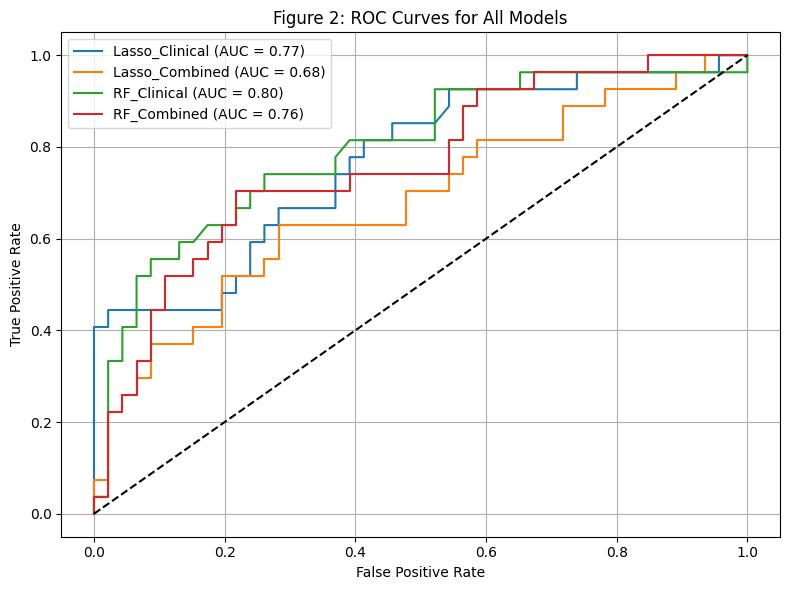

In [32]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for model, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f"{model} (AUC = {metrics['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 2: ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Figure 2: The ROC curve plot provides a visual comparison of the discriminative performance of all four models. Consistent with the performance summary table, the Random Forest model trained on clinical features alone (green line, AUC = 0.80) demonstrates the strongest performance, maintaining a higher true positive rate across a wide range of false positive rates. The Lasso model using only clinical features also performs reasonably well (blue line, AUC = 0.77), though slightly below RF_Clinical. Notably, both models that incorporate miRNA features — Lasso_Combined (orange) and RF_Combined (red) — show worse performance, with lower AUCs (0.68 and 0.76, respectively). The Lasso_Combined curve, in particular, lies closest to the diagonal line (chance performance), indicating that it struggles to distinguish between classes. Overall, the ROC curves reinforce the conclusion that adding miRNA predictors does not improve—and may slightly degrade—the predictive ability of the models compared to using clinical data alone.

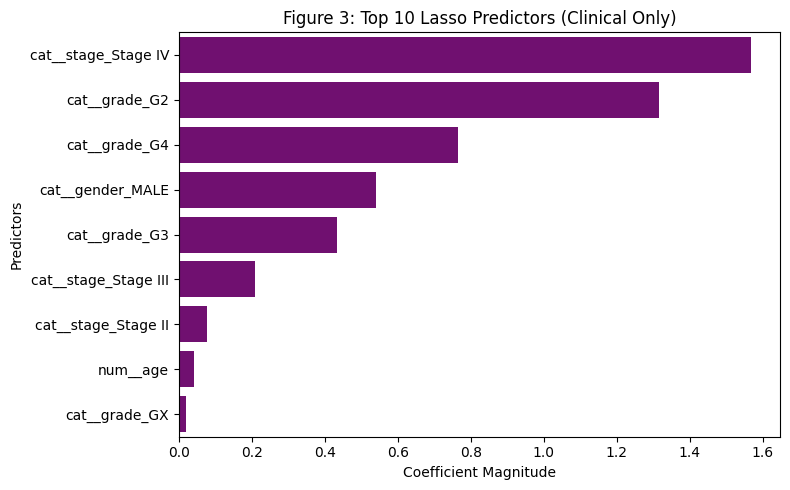

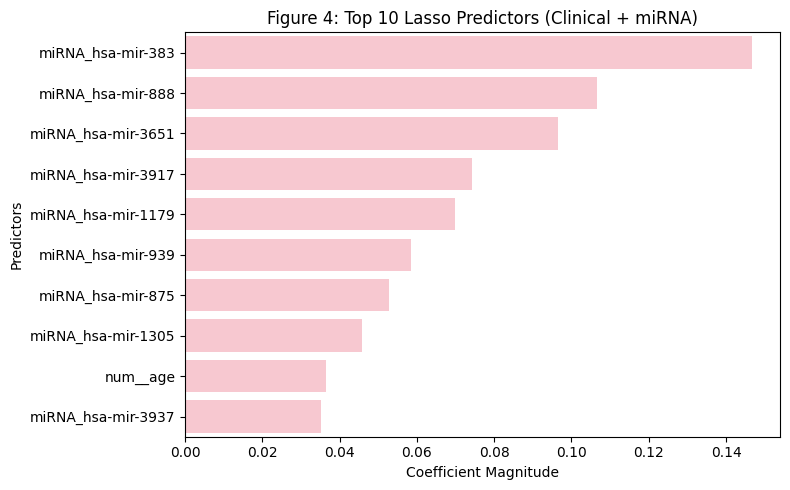

In [30]:
# --------------------- Lasso: Top 10 Coefficients ---------------------

# Clinical-only
lasso_coef_clinical = pd.Series(lasso_clinical.coef_[0], index=preprocessor.get_feature_names_out())
top_clinical = lasso_coef_clinical[lasso_coef_clinical != 0].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_clinical.values, y=top_clinical.index, color="purple")
plt.title("Figure 3: Top 10 Lasso Predictors (Clinical Only)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()

# Combined
miRNA_names = normalized_miRNA.columns.tolist()
combined_feature_names = list(preprocessor.get_feature_names_out()) + miRNA_names
lasso_coef_combined = pd.Series(lasso_combined.coef_[0], index=combined_feature_names)
top_combined = lasso_coef_combined[lasso_coef_combined != 0].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_combined.values, y=top_combined.index, color="pink")
plt.title("Figure 4: Top 10 Lasso Predictors (Clinical + miRNA)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()


##### Figure 3: Stage IV and Grade G2 have the largest absolute coefficients, which indivates that they were the strongest predictors of poor survival. Other important predictors incldue Stage III, Grade G4, and male gender, which also align with known clinical risk factors. Age has a much smaller coefficent, which suggest it is less informative in this cohort relative to cancer stage and grade. The plot confirms that clinical variables like stage and grade carry predictive importance when modeling overall survival. 

##### Figure 4: The top feautures of the Lasso model trained on the combined dating set have shifted to many more miRNAs such as miR--383, miR-888, and miR-3651. Clinical variables such as age appear more at the bottom of the list now, showing a reduced importance. However, even though miRNAs were chosen by the model as important predictors, their coefficients are much smaller than the top clinical predictors in figure 3. 

##### These plots suggest that while Lasso does identify some miRNAs as informative, they do not contribute as strongly to the model's predictions as well which aligns with the overall drop in performance in the combined model. 

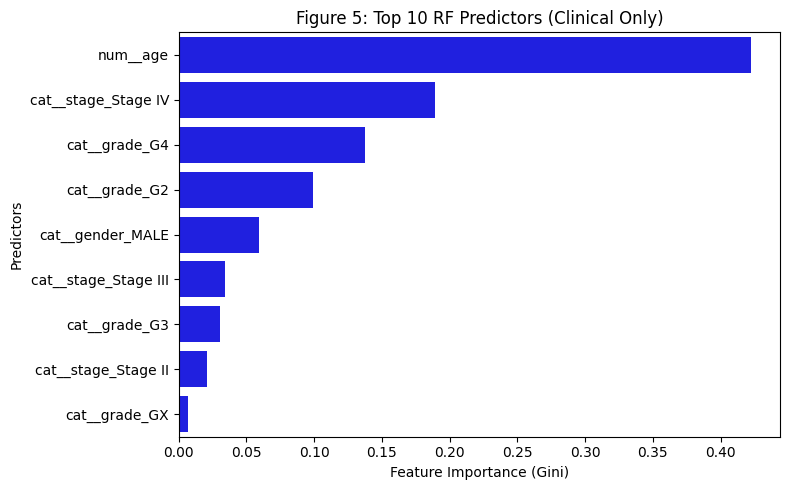

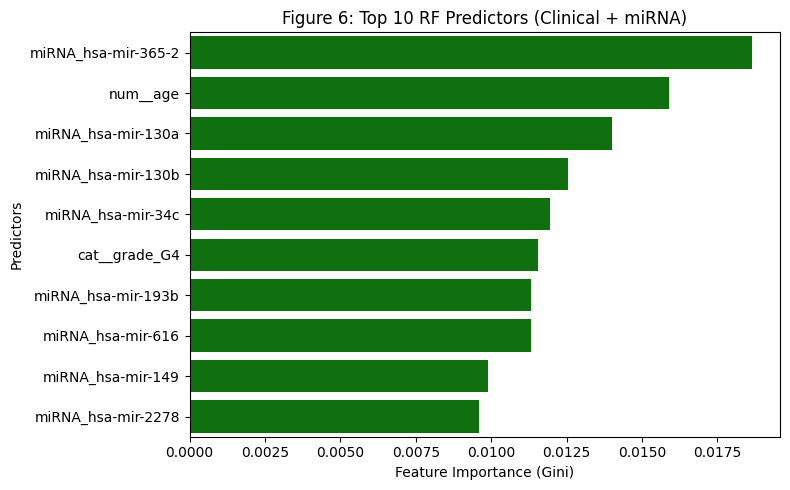

In [31]:
# --------------------- Random Forest: Top 10 Feature Importances ---------------------

# Clinical-only
rf_clinical_importances = pd.Series(rf_clinical.feature_importances_, index=preprocessor.get_feature_names_out())
top_rf_clinical = rf_clinical_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_rf_clinical.values, y=top_rf_clinical.index, color="blue")
plt.title("Figure 5: Top 10 RF Predictors (Clinical Only)")
plt.xlabel("Feature Importance (Gini)")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()

# Combined
rf_combined_importances = pd.Series(rf_combined.feature_importances_, index=combined_feature_names)
top_rf_combined = rf_combined_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_rf_combined.values, y=top_rf_combined.index, color="green")
plt.title("Figure 6: Top 10 RF Predictors (Clinical + miRNA)")
plt.xlabel("Feature Importance (Gini)")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()


##### Figure 5: For the Random Forest model which was trained only on clincal data, the most important efature were selected using Gini Impurity. The most important feature by far is age with a Gini importance exceeding 0.40, the highest among the other coefficients. The tumor stage, especially Stage IV, and grade, Grades G2  and G4, contribute significantly to model prediction. These predictors show that clinical predictors such as advances stage and higher tumor grade are strongly associated with poor survival of KIRC patients. 

##### Figure 6: When miRNAs are included as predictors, miRNA hsa-mir-365-2 becomes the top feature, just slightly ahead of age. Other miRNAs like mir-130a, mir-130b, mir-34c also follow. Clinical variables such as Grade G4 are pushed lower in importance. However, the absolute importance for all features are much smaller which indicates that model is more spread out among weaker predictors. 

##### This indicates that adding miRNA dilutes the influence of stronger clinical predictors. This may lead to the drop in performance as seen in the ROC curves and evaluation metrics. 

## Conclusion:

##### As seen through the comparison between the Lasso and Random Forest model performance, the main issues stem from preprocessing. This underscores the importance of reducing dimensionality as much as possible without removing complexities in the data. While Lasso models effectively penalized the less informative features, it is possible they excluded complex non-linear relationships between miRNA and KIRC. In contrast, the Random Forest models were able to recognize these subtleties to highlight possible miRNA predictors. However, the large number of miRNA features relative to the number of samples was another main reason for overfitting issues, especially in the combined models. Future work could explore a more targeting pre-processing approach where miRNAs are clustered based on organ-specific expression patterns or functional pathways, and then normalized. This would reduce redundancy and improve signal extraction seeing as there would be fewer features. Additionally, integrating the CNV and mRNA data from the KIRC dataset could also help with feature selection and enhance predictive accuracy. 